In [15]:
# removes annoying deprecation warnings 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import pandas as pd
from google.cloud import bigquery
from bq_helper import BigQueryHelper #third party library to translate google query data to dataframe
import matplotlib.pyplot as plt
import os, sys

sys.path.insert(0, './../utils/')

# custom files 
import random_forest_regressor as rfr
import utilities as util
import validation as cv

from sklearn.model_selection import train_test_split
from sklearn import cross_validation
%matplotlib inline

with open('../../key.txt') as f:
    content = f.readlines()

#add your own key here 
os.environ['GOOGLE_APPLICATION_CREDENTIALS']= content[0]

In [16]:
EPA_QUERY = """
        SELECT
            avg(arithmetic_mean) as am,
            CONCAT(cast(EXTRACT(YEAR FROM CO_daily.date_local) as string),
            cast(EXTRACT(MONTH FROM CO_daily.date_local) as string), 
            cast(EXTRACT(DAY FROM CO_daily.date_local) as string)) as date
        FROM
          `bigquery-public-data.epa_historical_air_quality.co_daily_summary` as CO_daily
        WHERE state_name ="California" AND city_name="San Francisco"
        GROUP BY date
        ORDER BY date DESC
        """

bq_assistant_CO = BigQueryHelper("bigquery-public-data", "epa_historical_air_quality")
df_CO = bq_assistant_CO.query_to_pandas(EPA_QUERY)

In [17]:
df_CO.head()

,am,date
0,0.593479,201799
1,0.595652,201798
2,0.600000,201797
3,0.591304,201796
4,0.557608,201795


In [18]:
SF_CRIME_QUERY = """
        SELECT
            COUNT( DISTINCT unique_key) as count,
            cast(EXTRACT(YEAR FROM SFCrimeData.timestamp)*10000 +
            EXTRACT(MONTH FROM SFCrimeData.timestamp)*100 + 
            EXTRACT(DAY FROM SFCrimeData.timestamp) as string) as date
        FROM
          `bigquery-public-data.san_francisco_sfpd_incidents.sfpd_incidents` AS SFCrimeData
        WHERE category = "NON-CRIMINAL"
        GROUP BY date
        ORDER BY date DESC
        """
bq_assistant_SF_crime = BigQueryHelper("bigquery-public-data", "san_francisco_sfpd_incidents.sfpd_incidents")
df_SF_crime = bq_assistant_SF_crime.query_to_pandas(SF_CRIME_QUERY)

In [19]:
df_SF_crime.head(n=10)

,count,date
0,1,20180515
1,8,20180514
2,22,20180513
3,28,20180512
4,19,20180511
5,33,20180510
6,17,20180509
7,27,20180508
8,40,20180507
9,36,20180506


In [20]:
df_SF_census = pd.read_csv('../../data/censuspopulationsf.tsv', sep='\t', header=None)
df_SF_census.columns = ['year', 'pop']
df_SF_census.head(n=10)

,year,pop
0,2003,757638
1,2004,750133
2,2005,748846
3,2006,751431
4,2007,758348
5,2008,767067
6,2009,774347
7,2010,805770
8,2011,816294
9,2012,830406


In [21]:
# make column for counts per capita
util.per_capita(df_SF_crime, df_SF_census)
# merge CO and Crime data
df_merged = util.merge_data(df_CO, df_SF_crime)
df_merged.head()

,am,date,count,per_capita
135,0.648188,20171231,57,0.000064
136,0.626177,20171230,51,0.000058
137,0.563949,20171229,46,0.000052
138,0.675906,20171228,46,0.000052
139,0.610960,20171227,41,0.000046


In [22]:
# find optimum regressor
regr = rfr.find_regressor(df_merged[['date','am']].as_matrix(), df_merged['per_capita'].values)
regr

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/home/kristina/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


[CV] n_estimators=250, min_samples_split=8, max_depth=50, bootstrap=True 
[CV] n_estimators=250, min_samples_split=8, max_depth=50, bootstrap=True 
[CV] n_estimators=250, min_samples_split=8, max_depth=50, bootstrap=True 
[CV] n_estimators=275, min_samples_split=4, max_depth=80, bootstrap=True 
[CV]  n_estimators=250, min_samples_split=8, max_depth=50, bootstrap=True, total=   0.3s
[CV] n_estimators=275, min_samples_split=4, max_depth=80, bootstrap=True 
[CV]  n_estimators=250, min_samples_split=8, max_depth=50, bootstrap=True, total=   0.4s
[CV]  n_estimators=250, min_samples_split=8, max_depth=50, bootstrap=True, total=   0.4s
[CV] n_estimators=275, min_samples_split=4, max_depth=80, bootstrap=True 
[CV] n_estimators=250, min_samples_split=2, max_depth=10, bootstrap=False 
[CV]  n_estimators=275, min_samples_split=4, max_depth=80, bootstrap=True, total=   0.4s
[CV] n_estimators=250, min_samples_split=2, max_depth=10, bootstrap=False 
[CV]  n_estimators=275, min_samples_split=4, max_d

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.9s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=70,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=175, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [23]:
# split dataset 
X_train, X_test, y_train, y_test = train_test_split(df_merged[['date','am']], df_merged['per_capita'].values, test_size=0.33, random_state=42)
# make predictions based on optimum regressor
y_pred = rfr.fit_and_predict(regr, X_train, X_test, y_train, y_test)

./../utils/random_forest_regressor.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  regr.fit(X_train.as_matrix(), y_train)
./../utils/random_forest_regressor.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  return regr.predict(X_test.as_matrix())


In [24]:
cv.MSE(y_test, y_pred)

1.4940334427923478e-10

In [25]:
# 10 fold tss cross validation
tss_score = cv.Cross_Validation(df_merged[['date','am']], df_merged['per_capita'], regr, 10)
print('10-fold cross validation using time series split (additive): {} '.format(tss_score))

10-fold cross validation using time series split (additive): 1.422831725482845e-10 


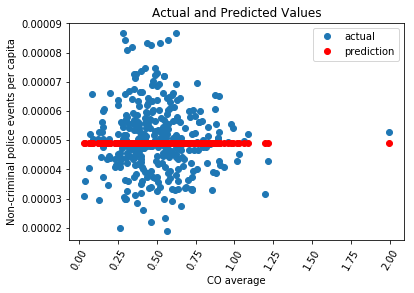

In [26]:
plt.plot(X_test['am'], y_test, 'o', label = 'actual')
plt.plot(X_test['am'], y_pred, 'ro', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()
plt.xlabel('CO average'); plt.ylabel('Non-criminal police events per capita'); plt.title('Actual and Predicted Values');

In [27]:
df_merged.corr()

,am,count,per_capita
am,1.000000,-0.126736,-0.073515
count,-0.126736,1.000000,0.975622
per_capita,-0.073515,0.975622,1.000000


In [13]:
SF_NON = """
        SELECT
          COUNT( DISTINCT unique_key) as count,
          CONCAT(cast(EXTRACT(YEAR FROM SFCrimeData.timestamp) AS string), 
          cast(EXTRACT(MONTH FROM SFCrimeData.timestamp) AS string), 
          cast(EXTRACT(DAY FROM SFCrimeData.timestamp) AS string)) AS date,
          descript as description
        FROM
          `bigquery-public-data.san_francisco_sfpd_incidents.sfpd_incidents` AS SFCrimeData
        WHERE category = "NON-CRIMINAL"
        GROUP BY descript, date
        ORDER BY date DESC
        """
df_SF_NON = bq_assistant_SF_crime.query_to_pandas(SF_NON)

In [14]:
set(df_SF_NON['description'])

{'ACCIDENTAL BURNS',
 'ACCIDENTAL LACERATIONS',
 'ACCIDENTAL SHOOTING',
 'AIDED CASE',
 'AIDED CASE -PROPERTY FOR DESTRUCTION',
 'AIDED CASE, DOG BITE',
 'AIDED CASE, INJURED PERSON',
 'AIDED CASE, MENTAL DISTURBED',
 'AIDED CASE, SICK PERSON',
 'AUTO IMPOUNDED',
 'CASE CLOSURE',
 'CIVIL SIDEWALKS, BOOKING',
 'CIVIL SIDEWALKS, CITATION',
 'CIVIL SIDEWALKS, VIOLATION',
 'CIVIL SIDEWALKS, WARNING',
 'COURTESY REPORT',
 'DEATH REPORT, CAUSE UNKNOWN',
 'DEATH REPORT, IN CUSTODY',
 'DEATH REPORT, NATURAL CAUSES',
 'DEATH, ACCIDENTAL',
 'DEATH, NON-MANSLAUGHTER AUTO ACCIDENT',
 'DEMONSTRATION, VIDEO EVIDENCE, MISC. INVESTIGATION',
 'FIRE REPORT',
 'FOUND PROPERTY',
 'IMPOUNDED VEHICLE',
 'LICENSE PLATE, FOUND',
 'LICENSE PLATE, RECOVERED',
 'LOCATED PROPERTY',
 'LOST PROPERTY',
 "MEGAN'S LAW NOTIFICATION",
 'MISPLACED VEHICLE',
 'PROPERTY FOR IDENTIFICATION',
 'SEARCH WARRANT SERVICE',
 'SHELTER',
 'STAY AWAY OR COURT ORDER, NON-DV RELATED',
 'TARASOFF REPORT',
 'TRAFFIC ACCIDENT',
 'TRUANT,

In [30]:
SF_FIRE = """
        SELECT
          COUNT( DISTINCT unique_key) as count,
          CONCAT(cast(EXTRACT(YEAR FROM SFCrimeData.timestamp) AS string), 
          cast(EXTRACT(MONTH FROM SFCrimeData.timestamp) AS string), 
          cast(EXTRACT(DAY FROM SFCrimeData.timestamp) AS string)) AS date
        FROM
          `bigquery-public-data.san_francisco_sfpd_incidents.sfpd_incidents` AS SFCrimeData
        WHERE category = "NON-CRIMINAL" AND descript="FIRE REPORT"
        GROUP BY descript, date
        ORDER BY date DESC
        """
df_SF_FIRE = bq_assistant_SF_crime.query_to_pandas(SF_FIRE)

In [31]:
# make column for counts per capita
util.per_capita(df_SF_FIRE, df_SF_census)
# merge CO and Crime data
df_merged = util.merge_data(df_CO, df_SF_FIRE)
df_merged.head()

,am,date,count,per_capita
45,0.287409,2017930,1,0.000001
46,0.489402,2017927,2,0.000002
47,0.482790,2017926,1,0.000001
48,0.296014,2017922,2,0.000002
49,0.286956,2017920,1,0.000001


In [32]:
# find optimum regressor
regr = rfr.find_regressor(df_merged[['date','am']].as_matrix(), df_merged['per_capita'].values)
regr

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/home/kristina/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


[CV] n_estimators=250, min_samples_split=8, max_depth=50, bootstrap=True 
[CV] n_estimators=250, min_samples_split=8, max_depth=50, bootstrap=True 
[CV] n_estimators=250, min_samples_split=8, max_depth=50, bootstrap=True 
[CV] n_estimators=275, min_samples_split=4, max_depth=80, bootstrap=True 
[CV]  n_estimators=250, min_samples_split=8, max_depth=50, bootstrap=True, total=   0.4s
[CV] n_estimators=275, min_samples_split=4, max_depth=80, bootstrap=True 
[CV]  n_estimators=250, min_samples_split=8, max_depth=50, bootstrap=True, total=   0.4s
[CV] n_estimators=275, min_samples_split=4, max_depth=80, bootstrap=True 
[CV]  n_estimators=250, min_samples_split=8, max_depth=50, bootstrap=True, total=   0.4s
[CV] n_estimators=250, min_samples_split=2, max_depth=10, bootstrap=False 
[CV]  n_estimators=275, min_samples_split=4, max_depth=80, bootstrap=True, total=   0.4s
[CV] n_estimators=250, min_samples_split=2, max_depth=10, bootstrap=False 
[CV]  n_estimators=275, min_samples_split=4, max_d

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    3.1s finished


RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [33]:
# split dataset 
X_train, X_test, y_train, y_test = train_test_split(df_merged[['date','am']], df_merged['per_capita'].values, test_size=0.33, random_state=42)
# make predictions based on optimum regressor
y_pred = rfr.fit_and_predict(regr, X_train, X_test, y_train, y_test)

./../utils/random_forest_regressor.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  regr.fit(X_train.as_matrix(), y_train)
./../utils/random_forest_regressor.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  return regr.predict(X_test.as_matrix())


In [34]:
cv.MSE(y_test, y_pred)

3.719187650277951e-13

In [35]:
# 10 fold tss cross validation
tss_score = cv.Cross_Validation(df_merged[['date','am']], df_merged['per_capita'], regr, 10)
print('10-fold cross validation using time series split (additive): {} '.format(tss_score))

10-fold cross validation using time series split (additive): 3.7593204106935054e-13 
